In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from epics import ca
from IPython.display import Image, display_png

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
exp_type = "peak_fwhm_nlpi"

In [4]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
!ls {data_base_dir}

peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_14:32.gz


### peak_fwhm_150_2022-11-18

In [6]:
!ls {data_base_dir}

peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_14:32.gz


In [7]:
log_file = Path(data_base_dir / "peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_14:32.gz")
log_file.exists()

True

In [8]:
hist_dir = Path(data_base_dir / "peak_fwhm_nlpi_moo_100_2022-11-21_steps")
hist_dir.exists()

True

In [9]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2023-07-25 11:10:05,964] A new study created in memory with name: no-name-2573b5e2-5ffc-4e56-81ec-aeb6bcb9720c


Assuming minimization for all objectives.


In [10]:
n_steps = len(study.trials)

In [11]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

Trial values: peak_distance 8.281e-02 fwhm 4.011e-02 nlpi -1.065e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39063298661392115, 'h_fwhm': 0.03771746178786728, 'h_centroid': -0.00507930528029768, 'h_peak': -0.07250856878184349, 'v_sigma': 0.457689515966432, 'v_fwhm': 0.013655334114889284, 'v_centroid': 0.008486443643079294, 'v_peak': -0.03999062133645954, 'integral_intensity': 285.23463791034146, 'peak_intensity': 42153.145, 'gaussian_fit': {}}}


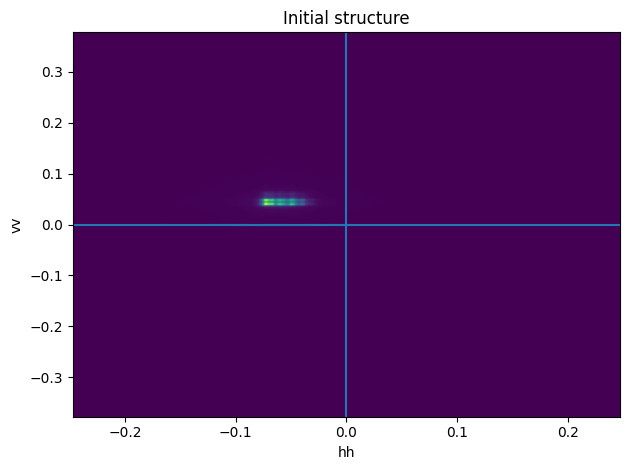

In [12]:
print(
    f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} "
    f"nlpi {study.trials[0].values[2]:4.3e}"
)
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)


plt.pcolormesh(hists[0].hh[700:-700], hists[0].vv[700:-700], hists[0].data_2D[700:-700, 700:-700].T)
plt.axhline(0)
plt.axvline(0)
plt.xlabel("hh")
plt.ylabel("vv")
plt.title("Initial structure")
plt.tight_layout()
plt.show()

In [13]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [17]:
tn = nash_trial.number

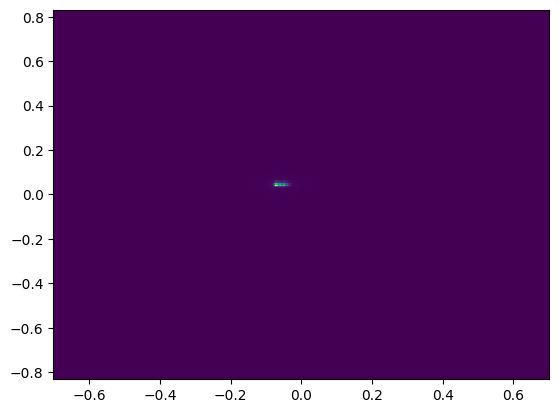

In [26]:
plt.pcolormesh(hists[0].hh, hists[0].vv, hists[0].data_2D.T)

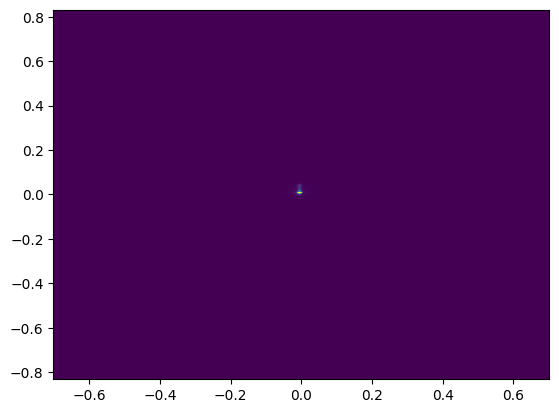

In [18]:
plt.pcolormesh(hists[tn].hh, hists[tn].vv, hists[tn].data_2D.T)

In [19]:
data_to_save = {"initial": hists[0], "optimized": hists[tn]}

In [21]:
np.savez("optimization_coma_raw_data_for_luca.npz", **data_to_save)

In [29]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[53, 54, 68, 63, 20, 57, 57, 71, 62, 14]
77 [0.012034626548241124, 0.014742877858418896, -11.088897705078125]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3917526845578378, 'h_fwhm': 0.011055118110236961, 'h_centroid': -0.0012383140398943004, 'h_peak': -0.009429365446966131, 'v_sigma': 0.45924454605224757, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.006272393729202852, 'v_peak': -0.007477921062915232, 'integral_intensity': 282.9832860306218, 'peak_intensity': 65440.574, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.014742877858418896


Trial number 19
Trial values: peak_distance 3.591e-03 fwhm 1.518e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3905650048591323, 'h_fwhm': 0.011055118110236961, 'h_centroid': -0.00014923123771573565, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.4578402389852559, 'v_fwhm': 0.010404064087534692, 'v_centroid': 0.005914265675858149, 'v_peak': -0.003576397030089868, 'integral_intensity': 285.068849385234, 'peak_intensity': 65142.484, 'gaussian_fit': {}}}
Actual fwhm 0.015180915188776279


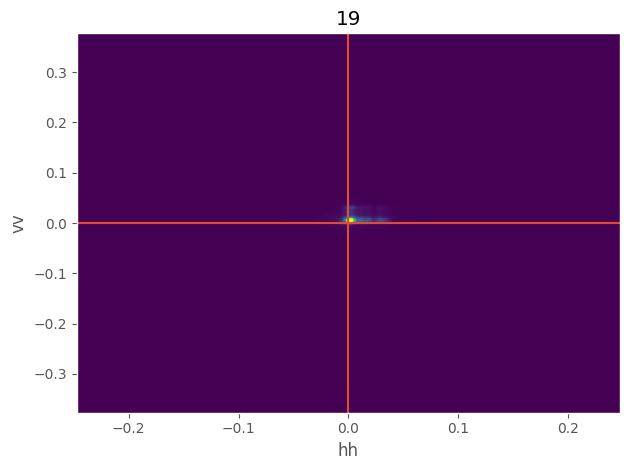

Trial number 36
Trial values: peak_distance 3.591e-03 fwhm 1.573e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39068677046867173, 'h_fwhm': 0.013656322371469187, 'h_centroid': -0.0003062280136606199, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.45795109732874745, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005955664730840776, 'v_peak': -0.003576397030089868, 'integral_intensity': 284.7598158938527, 'peak_intensity': 65184.168, 'gaussian_fit': {}}}
Actual fwhm 0.015728404236550825


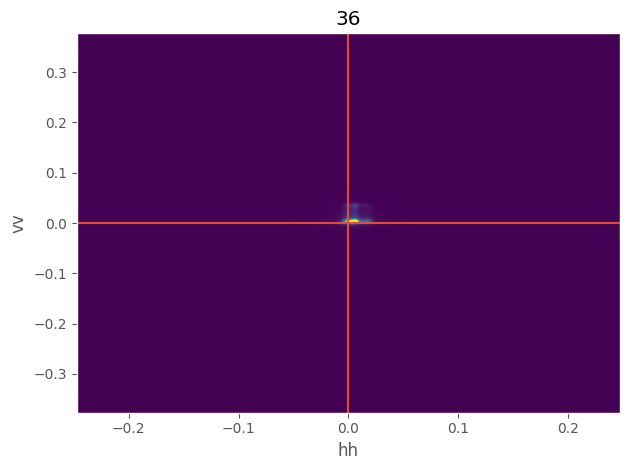

Trial number 50
Trial values: peak_distance 1.437e-02 fwhm 1.172e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3904756596276825, 'h_fwhm': 0.009754515979620848, 'h_centroid': -0.0007217267500834734, 'h_peak': -0.008779064381658213, 'v_sigma': 0.4577662242647119, 'v_fwhm': 0.006502540054709183, 'v_centroid': 0.006577692401852686, 'v_peak': -0.011379445095740596, 'integral_intensity': 284.91088209482393, 'peak_intensity': 65308.47, 'gaussian_fit': {}}}
Actual fwhm 0.011723208142815505


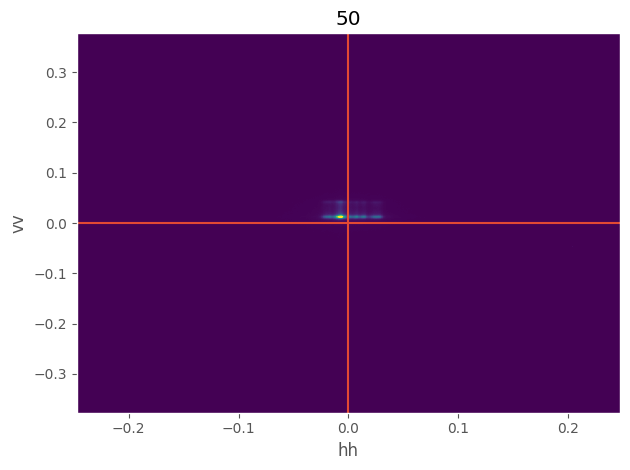

Trial number 52
Trial values: peak_distance 1.986e-02 fwhm 1.317e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.390930900548206, 'h_fwhm': 0.011055118110236961, 'h_centroid': 0.0010308589103857901, 'h_peak': 0.012680870773506308, 'v_sigma': 0.4580261590204794, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.004726936516298491, 'v_peak': 0.015280969128565813, 'integral_intensity': 284.8682035926864, 'peak_intensity': 65342.61, 'gaussian_fit': {}}}
Actual fwhm 0.01316731177190838


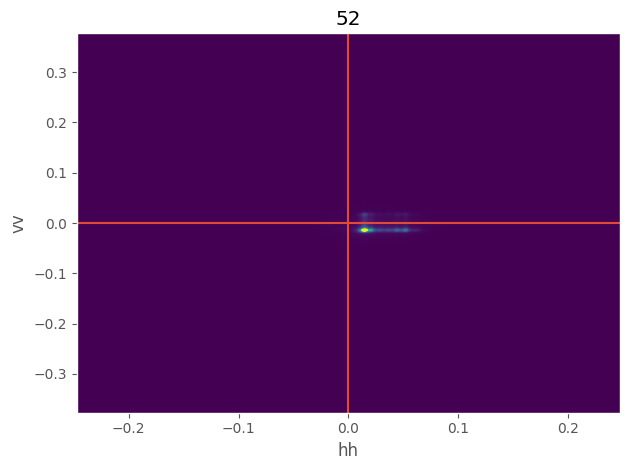

Trial number 57
Trial values: peak_distance 4.884e-02 fwhm 1.199e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.390791150433014, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.0021715986768683637, 'h_peak': -0.028938397406206604, 'v_sigma': 0.4580798634572702, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.003000552966626574, 'v_peak': 0.03934036733098855, 'integral_intensity': 284.5410648901891, 'peak_intensity': 65348.445, 'gaussian_fit': {}}}
Actual fwhm 0.011990591658498573


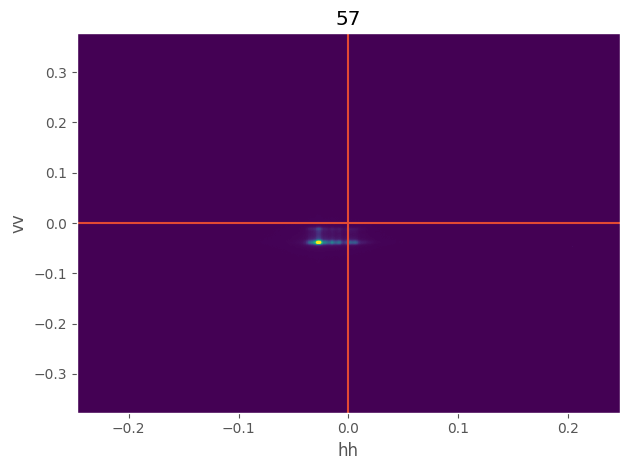

Trial number 64
Trial values: peak_distance 9.069e-03 fwhm 1.291e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39042058298575383, 'h_fwhm': 0.009754515979620848, 'h_centroid': 4.494099285551334e-05, 'h_peak': -0.0022760537285780058, 'v_sigma': 0.45778684300390593, 'v_fwhm': 0.008453302071121938, 'v_centroid': 0.005254378439199792, 'v_peak': 0.008778429073856921, 'integral_intensity': 284.6812246635373, 'peak_intensity': 65200.895, 'gaussian_fit': {}}}
Actual fwhm 0.012907706918826166


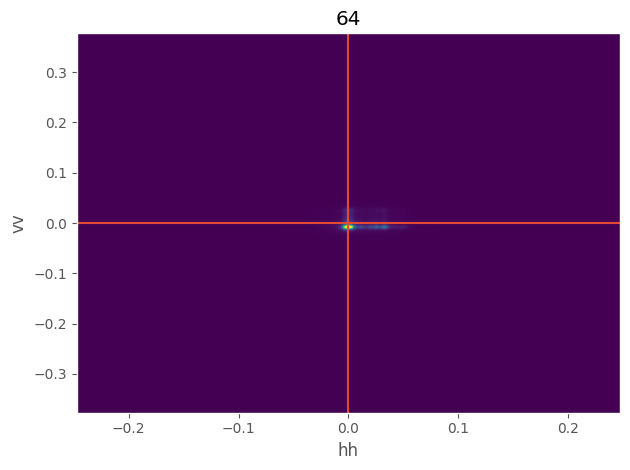

Trial number 65
Trial values: peak_distance 7.019e-03 fwhm 1.444e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39055831841404076, 'h_fwhm': 0.011705419175545018, 'h_centroid': -0.0004827783027132049, 'h_peak': -0.006828161185734166, 'v_sigma': 0.4578184968684027, 'v_fwhm': 0.008453302071121938, 'v_centroid': 0.005900284641996184, 'v_peak': -0.0016256350136773334, 'integral_intensity': 285.0170776828947, 'peak_intensity': 65230.117, 'gaussian_fit': {}}}
Actual fwhm 0.014438668705280672


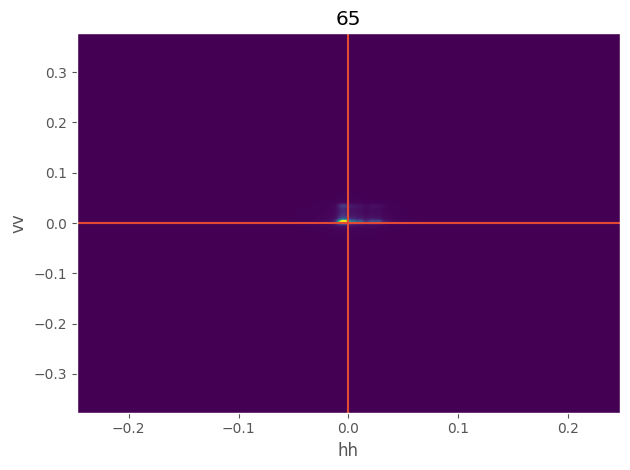

Trial number 77
Trial values: peak_distance 1.203e-02 fwhm 1.474e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3917526845578378, 'h_fwhm': 0.011055118110236961, 'h_centroid': -0.0012383140398943004, 'h_peak': -0.009429365446966131, 'v_sigma': 0.45924454605224757, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.006272393729202852, 'v_peak': -0.007477921062915232, 'integral_intensity': 282.9832860306218, 'peak_intensity': 65440.574, 'gaussian_fit': {}}}
Actual fwhm 0.014742877858418896


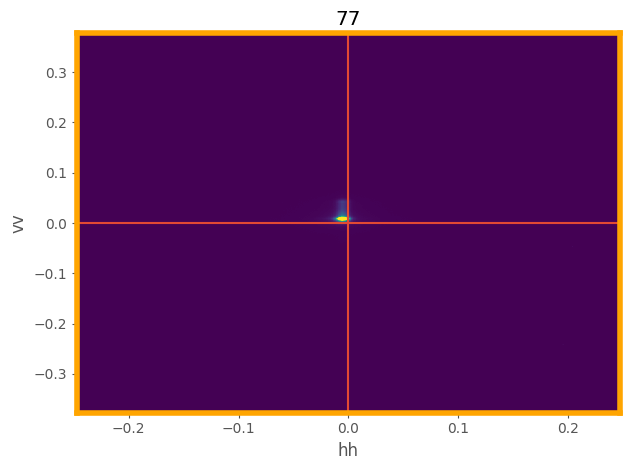

Trial number 80
Trial values: peak_distance 1.138e-02 fwhm 1.535e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39158006316121, 'h_fwhm': 0.012355720240853074, 'h_centroid': -0.0005483100804433705, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.4590939034572857, 'v_fwhm': 0.009103556076592856, 'v_centroid': 0.0049985526299919925, 'v_peak': 0.011379445095740449, 'integral_intensity': 283.51418278168813, 'peak_intensity': 65321.793, 'gaussian_fit': {}}}
Actual fwhm 0.015347265421237006


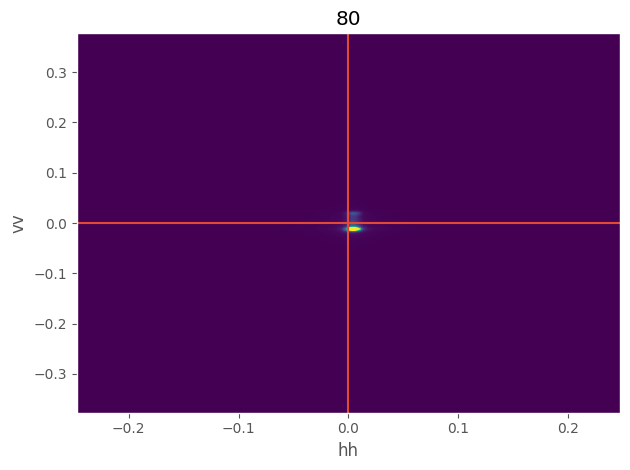

Trial number 100
Trial values: peak_distance 5.846e-02 fwhm 1.334e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39119259188274974, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.0010075673388159068, 'h_peak': -0.005527559055118184, 'v_sigma': 0.45885890726875084, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.0022376369691274045, 'v_peak': 0.058197733489644375, 'integral_intensity': 283.83829041745156, 'peak_intensity': 65446.844, 'gaussian_fit': {}}}
Actual fwhm 0.013342546245861935


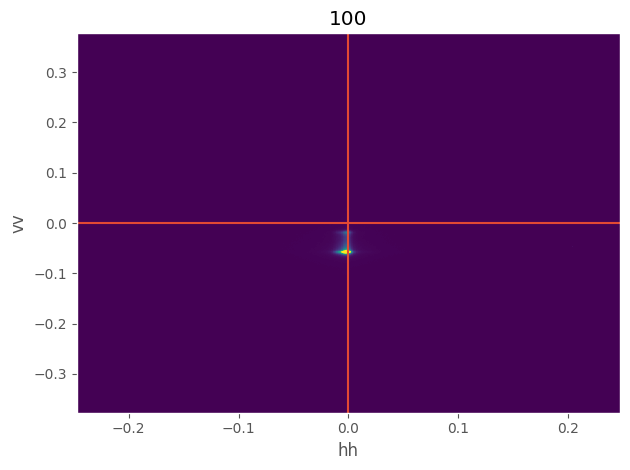

In [30]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700, 700:-700].T)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.xlabel("hh")
    plt.ylabel("vv")
    plt.axhline(0)
    plt.axvline(0)
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [18]:
study.best_trials[0].values

[0.003591147252024175, 0.015180915188776279, -11.084332466125488]

In [19]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ["peak_distance", "fwhm", "nlpi"])

In [20]:
pareto_df

number  peak_distance      fwhm       nlpi    h_peak    v_peak    h_fwhm  \
19       19       0.003591  0.015181 -11.084332 -0.000325 -0.003576  0.011055   
36       36       0.003591  0.015728 -11.084972 -0.000325 -0.003576  0.013656   
50       50       0.014372  0.011723 -11.086877 -0.008779 -0.011379  0.009755   
52       52       0.019857  0.013167 -11.087399  0.012681  0.015281  0.011055   
57       57       0.048837  0.011991 -11.087489 -0.028938  0.039340  0.009104   
64       64       0.009069  0.012908 -11.085229 -0.002276  0.008778  0.009755   
65       65       0.007019  0.014439 -11.085676 -0.006828 -0.001626  0.011705   
77       77       0.012035  0.014743 -11.088898 -0.009429 -0.007478  0.011055   
80       80       0.011384  0.015347 -11.087081 -0.000325  0.011379  0.012356   
100     100       0.058460  0.013343 -11.088994 -0.005528  0.058198  0.009104   

       v_fwhm  peak_intensity  
19   0.010404    65142.484375  
36   0.007803    65184.167969  
50   0.006503    65308.468750  
52   0.007153    65342.609375  
57   0.007803    65348.445312  
64   0.008453    65200.894531  
65   0.008453    65230.117188  
77   0.009754    65440.574219  
80   0.009104    65321.792969  
100  0.009754    65446.843750

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/2812346178.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(


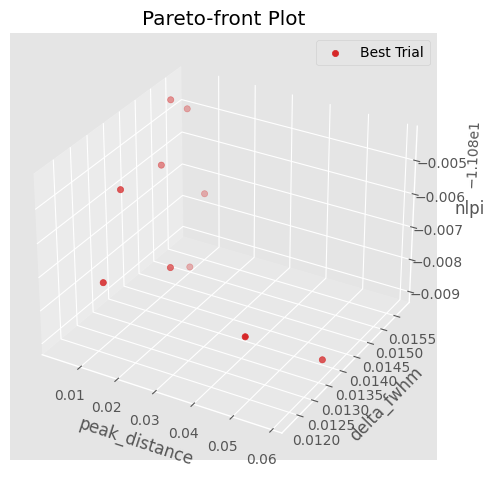

In [21]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(
    study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False
)
# plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc="best")
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/3707238885.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


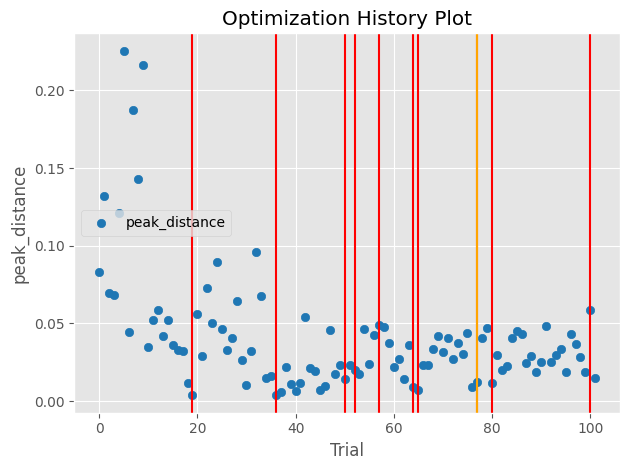

In [22]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: t.values[0], target_name="peak_distance"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/1220722967.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="fwhm")


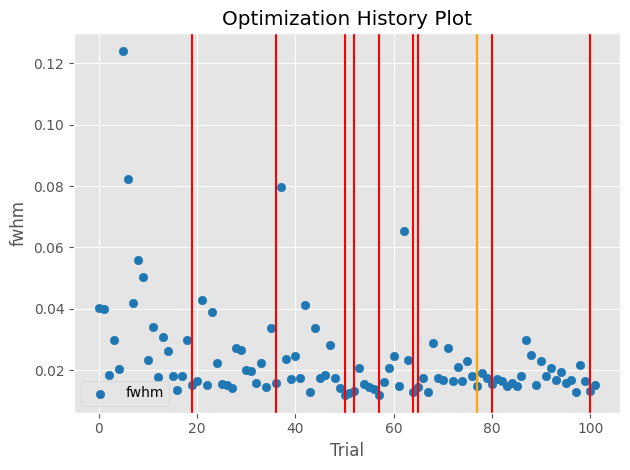

In [23]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/2046894989.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")


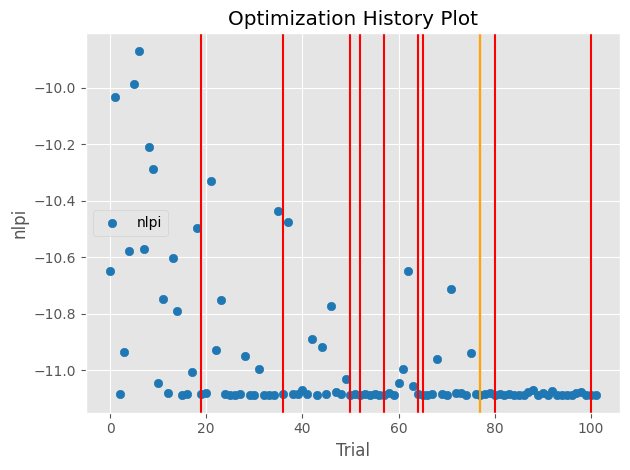

In [24]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [33]:
cp = opt_common.CalculationParameters(
    calculate_over_noise=True,
    noise_threshold=1.5,
)

In [35]:
new_hists = []
new_dws = []
for h in hists:
    h1, dw = analysis.recalculate_info(cp, h, crop=500)
    new_hists.append(h1)
    new_dws.append(dw)

In [40]:
wsums = [opt_common._get_weighted_sum_intensity_from_hist(cp, h1, 2) for h1 in new_hists]

In [41]:
wsums = np.array(wsums)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/529964445.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


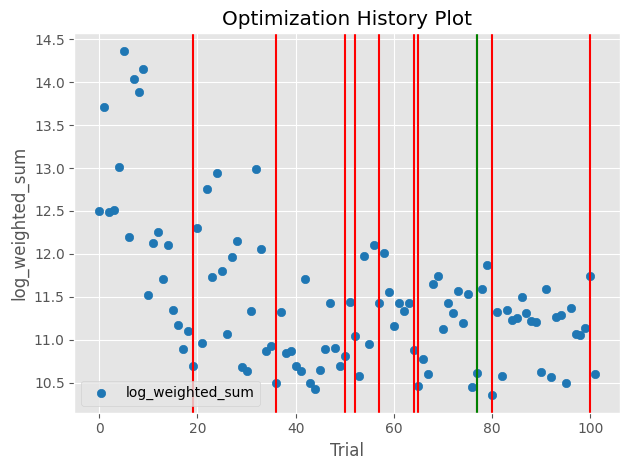

In [42]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: np.log(wsums[t.number]), target_name="log_weighted_sum"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/2610489323.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


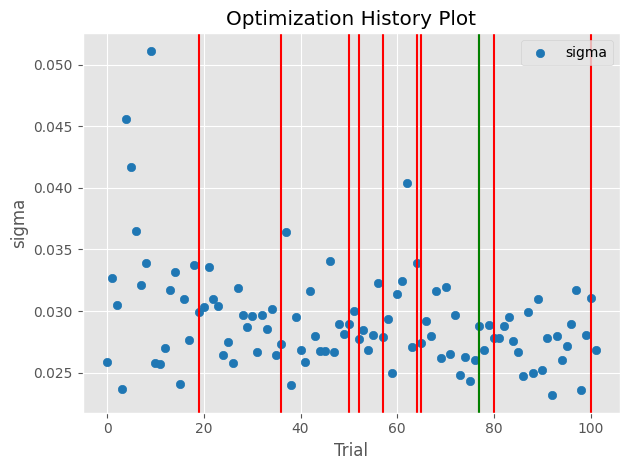

In [43]:
# Plotting the optimization histories
sigmas = [opt_common._get_sigma_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: sigmas[t.number], target_name="sigma"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/514347877.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number], target_name="fwhm")


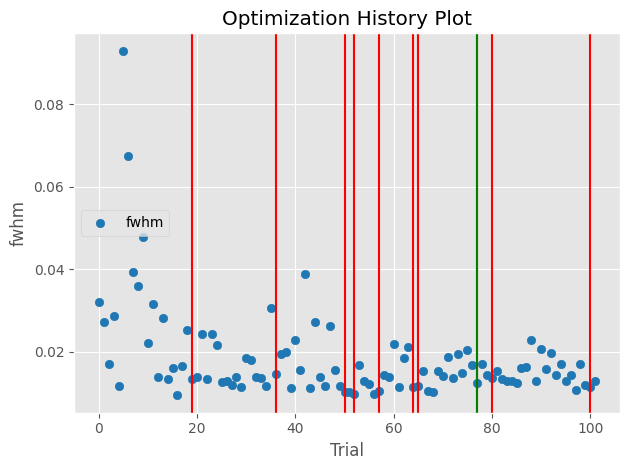

In [44]:
# Plotting the optimization histories
fwhms = [opt_common._get_fwhm_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number], target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/842371023.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


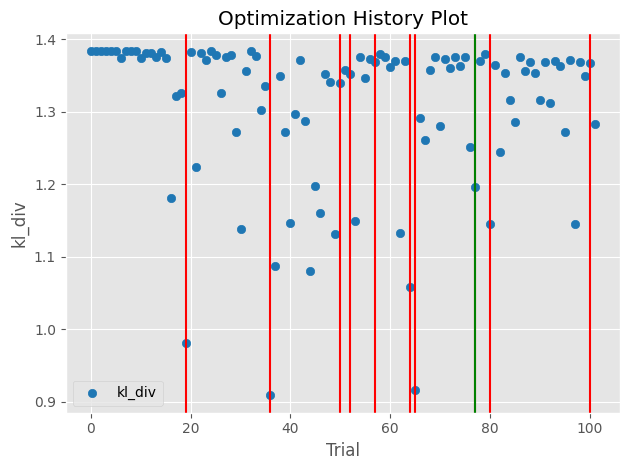

In [48]:
# Plotting the optimization histories
kl_divs = [opt_common._get_kl_divergence_with_gaussian_from_hist(cp,hist, reference_h=5e-3, refernece_v=5e-3) for hist in new_hists]
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: kl_divs[t.number], target_name="kl_div"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/2462889431.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


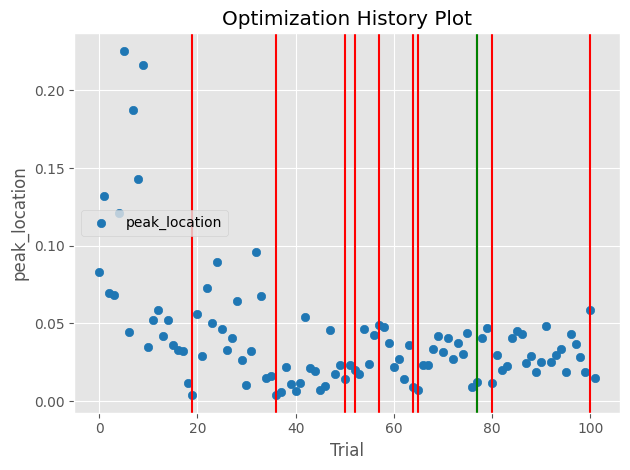

In [49]:
# Plotting the optimization histories
plocs = [opt_common._get_peak_distance_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: plocs[t.number], target_name="peak_location"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25319/468634669.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


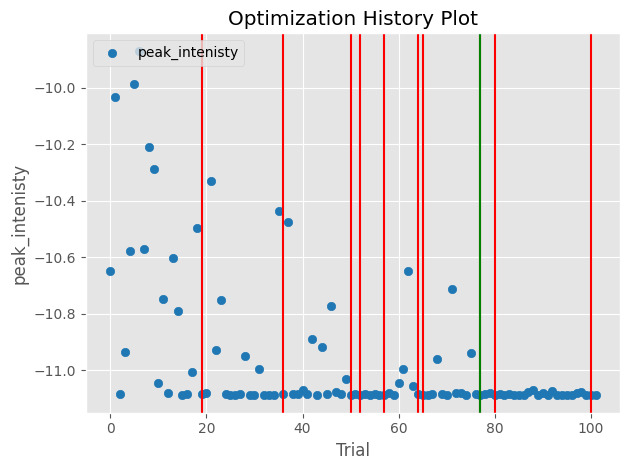

In [70]:
# Plotting the optimization histories
pints = [-np.log(opt_common._get_peak_intensity_from_dw(dw)) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: pints[t.number], target_name="peak_intenisty"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [68]:
# peak_location, fwhm, nlpi

test_val_fns = [
    lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
    lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
    lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])),
    
]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

77 13


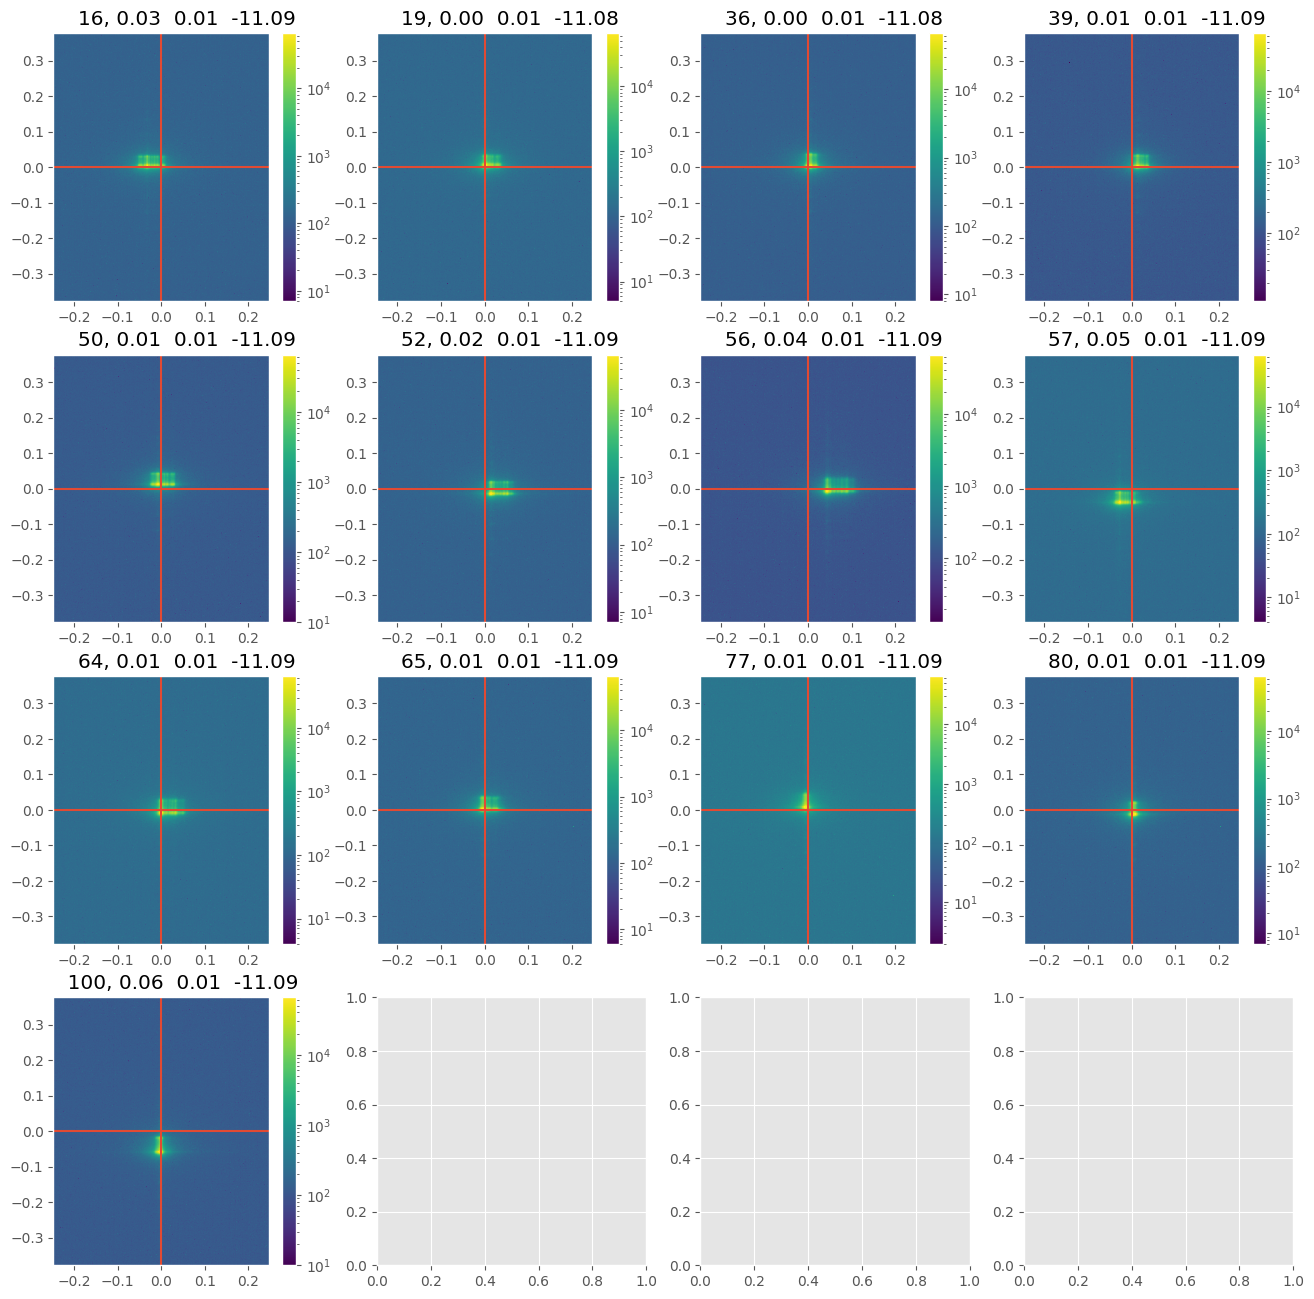

In [69]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [51]:
np.argmin(kl_divs)

36

In [54]:
# FWHM, WSUM

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]), lambda t: np.log(wsums[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

43 7


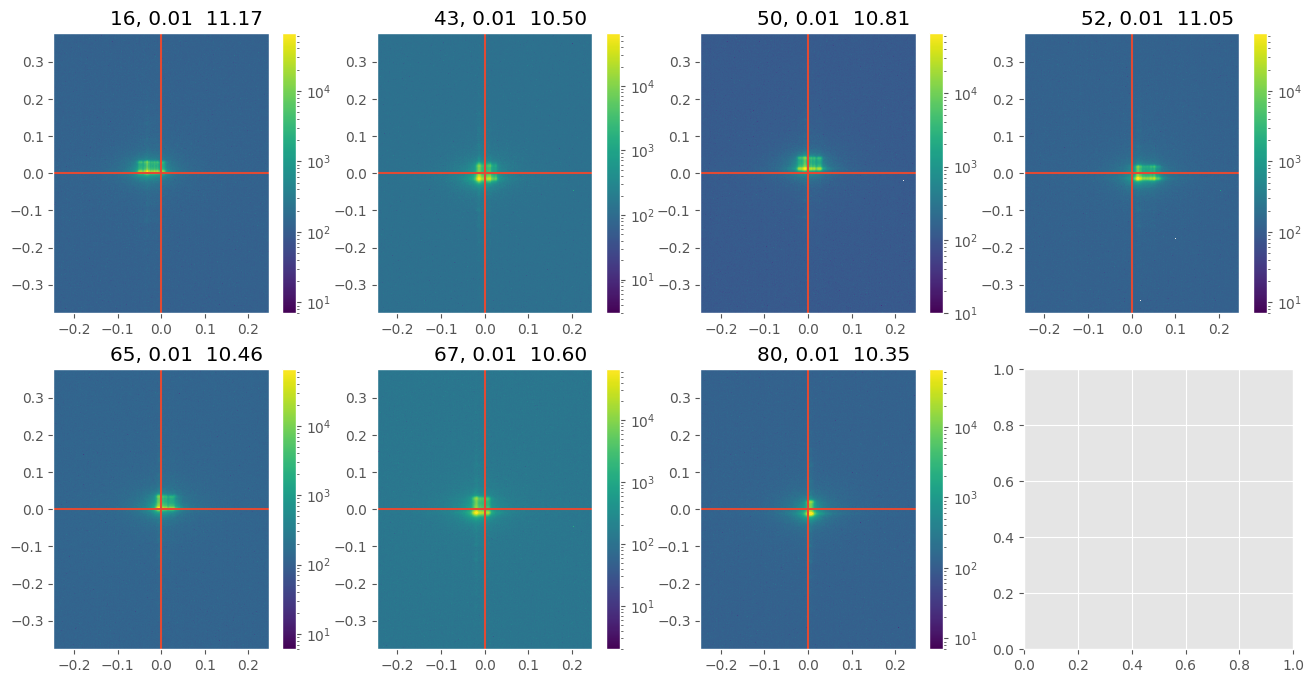

In [55]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [57]:
# FWHM, KL

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]), lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

16 5


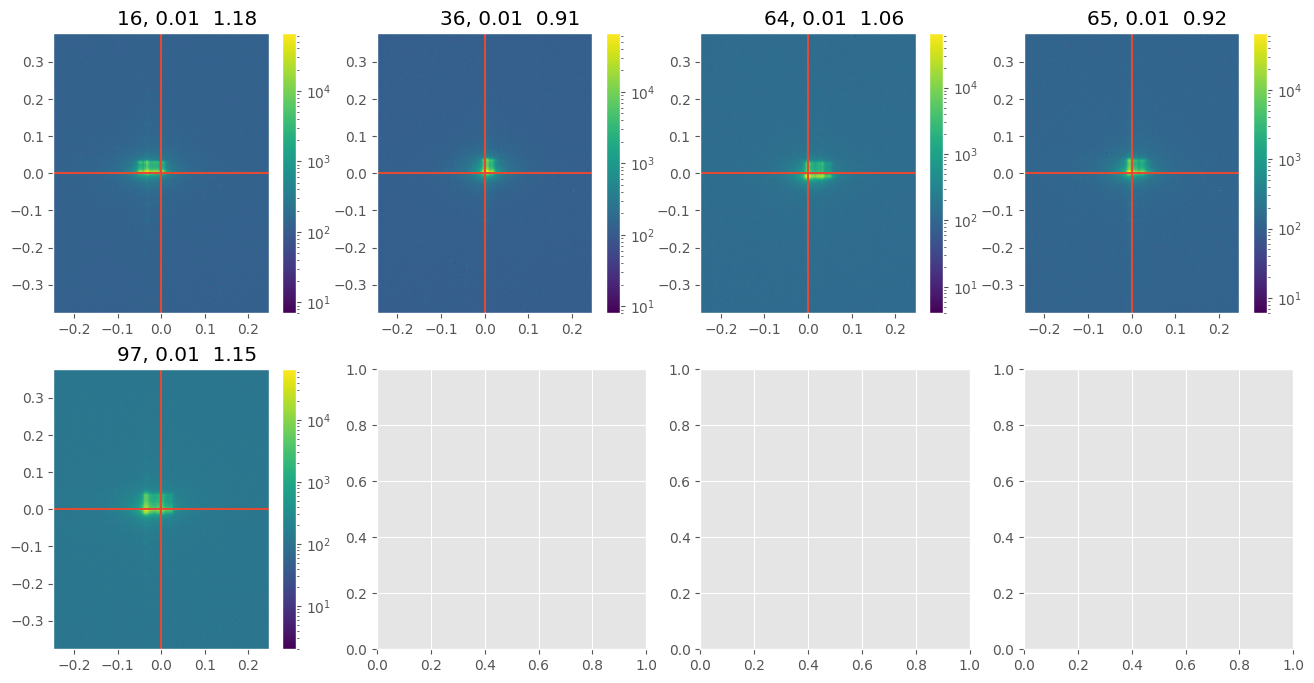

In [58]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [60]:
# sigma, KL

test_val_fns = [lambda t: opt_common._get_sigma_from_dw(new_dws[t.number]), lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

44 6


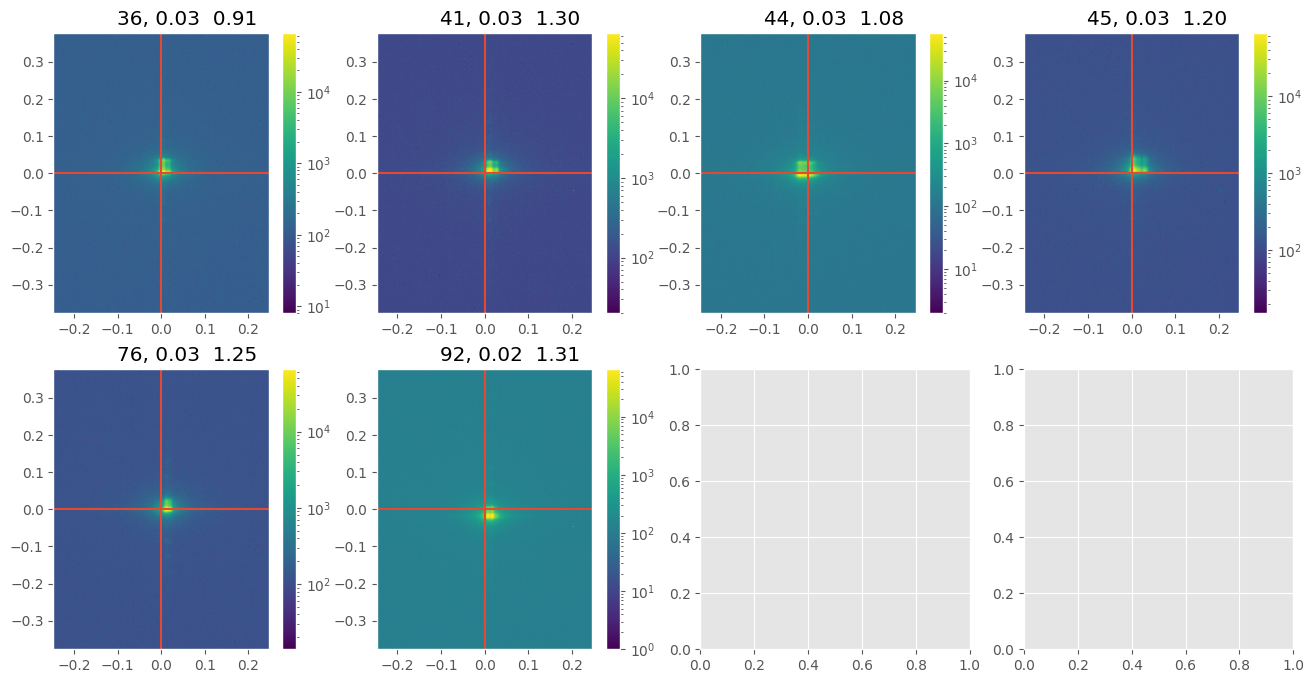

In [61]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [62]:
# peak_location, KL

test_val_fns = [lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]), lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

36 1


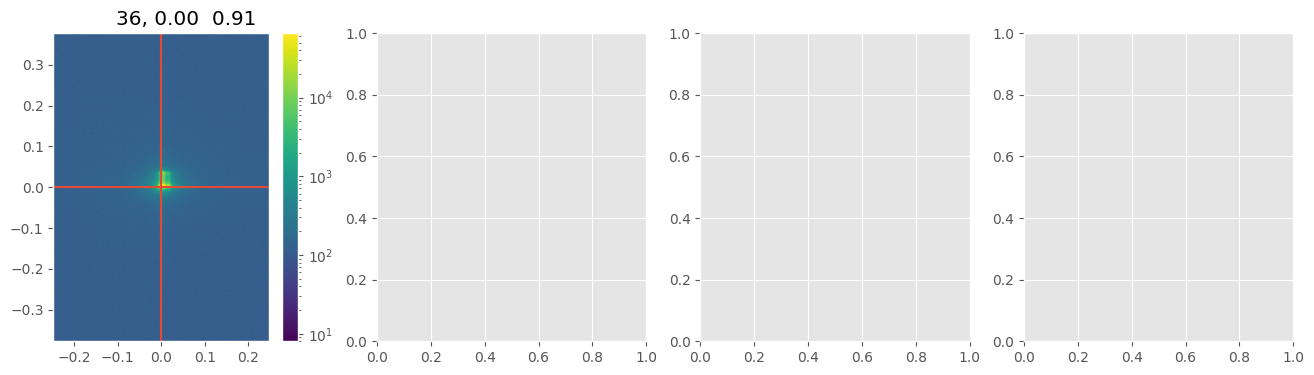

In [63]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [64]:
# peak_intensity, KL

test_val_fns = [
    lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])),
    lambda t: kl_divs[t.number],
]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

77 5


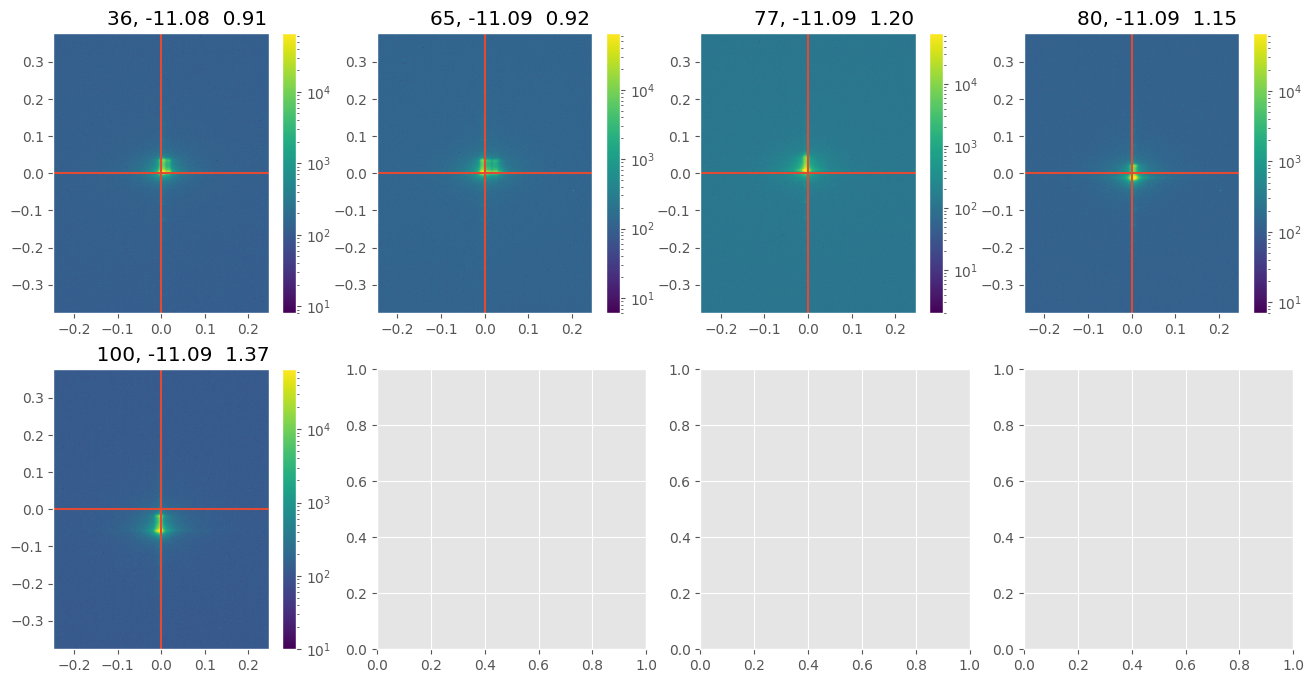

In [65]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [66]:
# peak_intensity, peak_location, KL

test_val_fns = [
    lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])),
    lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
    lambda t: kl_divs[t.number],
]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

77 5


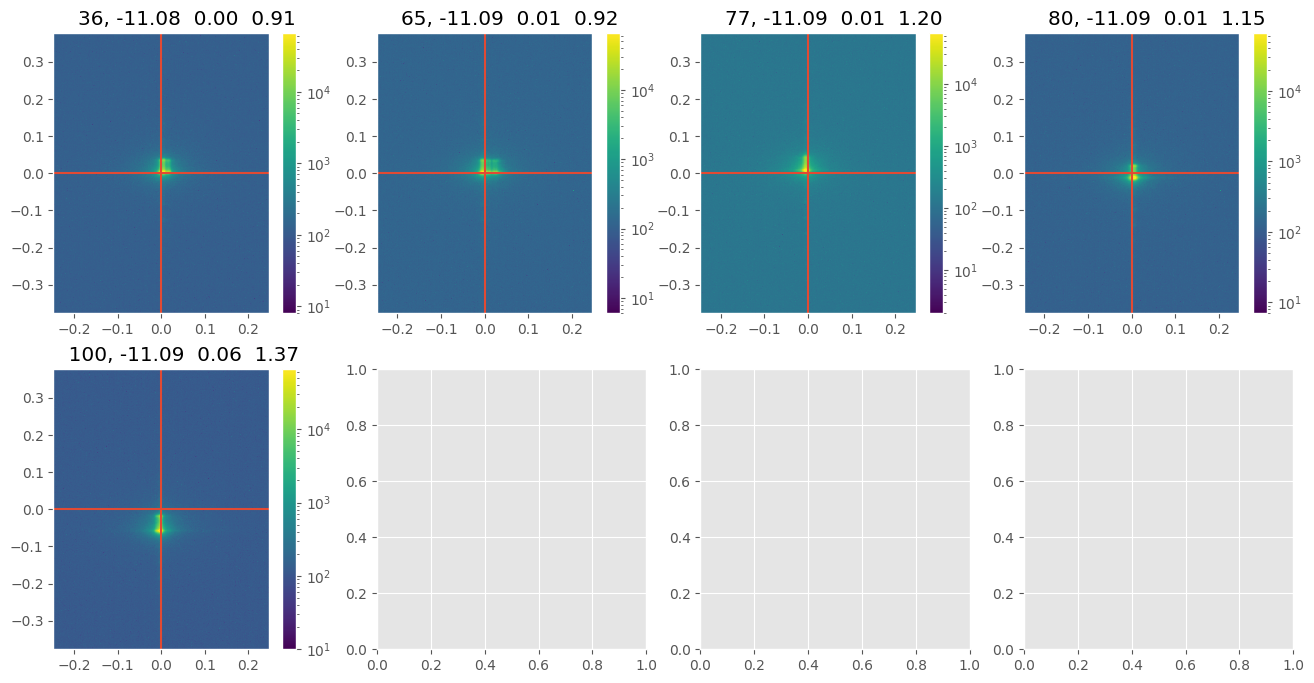

In [67]:
n_rows = np.ceil(len(test_pareto) / 4).astype("int")

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    hdata = hists[t.number]

    cax = axs[i].pcolormesh(
        hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T, norm=mpl.colors.LogNorm()
    )
    axs[i].axvline(0)
    axs[i].axhline(0)

    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()